In [5]:
import os
import glob
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D,AveragePooling2D, Flatten, Dropout 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [6]:
# hyperparameter setting
image_size = 256
batch_size = 32
epochs = 35

In [7]:
# input files

base_dir='/kaggle/input/leaf-class-main-2/Train'

lable_list = os.listdir(base_dir)

dataset = []

for i in range(len(lable_list)):
  path = base_dir + '/' + lable_list[i]
  dataset.append(glob.glob(path + '/*'))
  print(f'{lable_list[i]} : {len(dataset[i])}')

Tomato___Late_blight : 3702
Tomato___healthy : 3852
Grape___healthy : 3384
Potato___healthy : 3648
Corn_(maize)___Northern_Leaf_Blight : 3816
Tomato___Early_blight : 3840
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot : 3284
Tomato___Bacterial_spot : 3404
Pepper,_bell___healthy : 3976
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) : 3444
Potato___Late_blight : 3878
Grape___Black_rot : 3776
Potato___Early_blight : 3878
Corn_(maize)___Common_rust_ : 3814
Grape___Esca_(Black_Measles) : 3840
Pepper,_bell___Bacterial_spot : 3826
Corn_(maize)___healthy : 3718


In [8]:
# add labels

def add_labels(data, label):
    return list(map(lambda x: (x, label), data))

dataset_label = []

for i in range(len(lable_list)):
  files = add_labels(dataset[i], lable_list[i])
  dataset_label.append(files)
  print(dataset_label[i][0])

('/kaggle/input/leaf-class-main-2/Train/Tomato___Late_blight/781e93a9-2059-42de-8075-658033a6abf7___RS_Late.B 6075.JPG', 'Tomato___Late_blight')
('/kaggle/input/leaf-class-main-2/Train/Tomato___healthy/4a1e2b71-992a-4a64-a599-b49b8fa75378___RS_HL 0627.JPG', 'Tomato___healthy')
('/kaggle/input/leaf-class-main-2/Train/Grape___healthy/2dacf3f7-797b-4d4c-bf77-1d1a8f6d965d___Mt.N.V_HL 9117(1).JPG', 'Grape___healthy')
('/kaggle/input/leaf-class-main-2/Train/Potato___healthy/414f6249-9f78-4af5-9593-9d5a7e7d979f___RS_HL 1918_270deg(1).JPG', 'Potato___healthy')
('/kaggle/input/leaf-class-main-2/Train/Corn_(maize)___Northern_Leaf_Blight/c2e5ab9e-e705-4f13-9c50-1243e8ea0255___RS_NLB 3555_flipTB(1).JPG', 'Corn_(maize)___Northern_Leaf_Blight')
('/kaggle/input/leaf-class-main-2/Train/Tomato___Early_blight/24455ffa-8700-475c-8b4e-a7775f40ad3f___RS_Erly.B 8365_180deg(1).JPG', 'Tomato___Early_blight')
('/kaggle/input/leaf-class-main-2/Train/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/527b87bb-91

In [9]:
# split the data
def split_data(data):
    train_data, test_data = train_test_split(data, test_size=0.15)
    train_data, val_data = train_test_split(train_data, test_size=0.15)
    return [train_data, val_data, test_data]

dataset_data = []

for i in range(len(lable_list)):
  data = split_data(dataset_label[i])
  dataset_data.append(data)

In [10]:
# collect data
train_data = []
val_data = []
test_data = []

def collect(data):
    global train_data, val_data, test_data
    for sample in data[0]:
        train_data.append(sample)
    
    for sample in data[1]:
        val_data.append(sample)
        
    for sample in data[2]:
        test_data.append(sample)

for i in range(len(lable_list)):
  collect(dataset_data[i])
    
# convert them into dataframes
train_df = pd.DataFrame(train_data, columns=['image', 'label'])
val_df = pd.DataFrame(val_data, columns=['image', 'label'])
test_df = pd.DataFrame(test_data, columns=['image', 'label'])

print(len(train_df), len(val_df), len(test_df))

45562 8049 9469


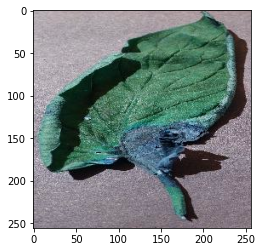

In [11]:
plt.figure()
image = cv2.imread(train_df['image'][0])
plt.imshow(image)

In [12]:
# data augmentation (train)

train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=10,
                               zoom_range = 0.1,
                               shear_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True)

train_set = train_gen.flow_from_dataframe(dataframe=train_df,
                                          x_col='image',
                                          y_col='label',
                                          target_size=(image_size, image_size),
                                          batch_size=batch_size,
                                          shuffle=True,
                                          class_mode='categorical',
                                          color_mode='grayscale')

# rescaling (validation)
val_rescaled = ImageDataGenerator(rescale = 1./255)

val_set = val_rescaled.flow_from_dataframe(dataframe=val_df,
                                           x_col='image',
                                           y_col='label',
                                           target_size=(image_size, image_size),
                                           batch_size=batch_size,
                                           shuffle=True,
                                           class_mode='categorical',
                                           color_mode='grayscale')

# rescaling (test)
test_rescaled = ImageDataGenerator(rescale = 1./255)

test_set = test_rescaled.flow_from_dataframe(dataframe=test_df,
                                             x_col='image',
                                             y_col='label',
                                             target_size=(image_size, image_size),
                                             batch_size=1,
                                             shuffle=False,
                                             class_mode='categorical',
                                             color_mode='grayscale')

Found 45562 validated image filenames belonging to 17 classes.
Found 8049 validated image filenames belonging to 17 classes.
Found 9469 validated image filenames belonging to 17 classes.


In [12]:
# build the model

# pretrained_model = MobileNet(input_shape=(image_size, image_size, 3),
#                          include_top=False,
#                          weights='imagenet')

model = Sequential([
    Conv2D(filters = 32, kernel_size = (5,5), padding = 'same', 
           activation ='relu', input_shape = (image_size, image_size, 1)),
    AveragePooling2D(pool_size=(2,2)),
    
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation ='relu'),
    AveragePooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation ='relu'),
    AveragePooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation ='relu'),
    AveragePooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.4),
    Dense(len(lable_list), activation='softmax')
])

# model.layers[0].trainable = False

In [13]:
# model configuration
model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', 
                   patience=8, 
                   restore_best_weights=True)

# lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
#                                  patience = 4, 
#                                  verbose=1,
#                                  factor=0.5, 
#                                  min_lr=0.00005)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      832       
_________________________________________________________________
average_pooling2d (AveragePo (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
average_pooling2d_2 (Average (None, 32, 32, 128)       0

In [14]:
history = model.fit_generator(train_set,
                              steps_per_epoch=len(train_set),
                              epochs=epochs,
                              validation_data=val_set,
                              validation_steps=len(val_set),
                              callbacks=[es]) 

Epoch 1/35
1424/1424 [==============================] - 548s 383ms/step - loss: 1.8883 - accuracy: 0.3808 - val_loss: 0.6985 - val_accuracy: 0.7623
Epoch 2/35
1424/1424 [==============================] - 342s 240ms/step - loss: 0.7866 - accuracy: 0.7267 - val_loss: 0.3885 - val_accuracy: 0.8581
Epoch 3/35
1424/1424 [==============================] - 345s 242ms/step - loss: 0.5119 - accuracy: 0.8181 - val_loss: 0.2699 - val_accuracy: 0.9021
Epoch 4/35
1424/1424 [==============================] - 344s 242ms/step - loss: 0.4143 - accuracy: 0.8518 - val_loss: 0.2482 - val_accuracy: 0.9114
Epoch 5/35
1424/1424 [==============================] - 343s 241ms/step - loss: 0.3621 - accuracy: 0.8677 - val_loss: 0.2159 - val_accuracy: 0.9222
Epoch 6/35
1424/1424 [==============================] - 314s 220ms/step - loss: 0.3208 - accuracy: 0.8845 - val_loss: 0.1983 - val_accuracy: 0.9241
Epoch 7/35
1424/1424 [==============================] - 307s 216ms/step - loss: 0.2827 - accuracy: 0.8960 - val_

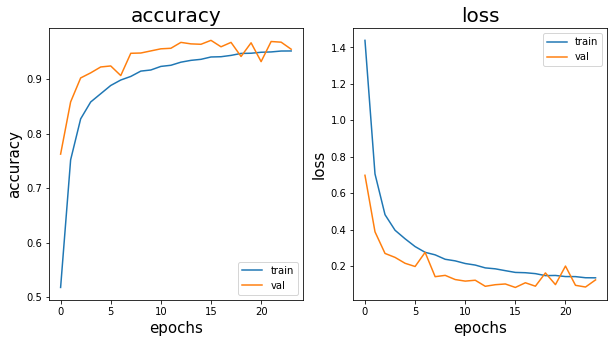

In [17]:
# plot the accuracy and loss of the model
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i, e in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[e])
    ax[i].plot(history.history['val_' + e])
    ax[i].set_title(e, fontsize=20)
    ax[i].set_xlabel('epochs', fontsize=15)
    ax[i].set_ylabel(e, fontsize=15)
    ax[i].legend(['train', 'val'])

0 : Tomato___Late_blight
1 : Tomato___healthy
2 : Grape___healthy
3 : Potato___healthy
4 : Corn_(maize)___Northern_Leaf_Blight
5 : Tomato___Early_blight
6 : Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
7 : Tomato___Bacterial_spot
8 : Pepper,_bell___healthy
9 : Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
10 : Potato___Late_blight
11 : Grape___Black_rot
12 : Potato___Early_blight
13 : Corn_(maize)___Common_rust_
14 : Grape___Esca_(Black_Measles)
15 : Pepper,_bell___Bacterial_spot
16 : Corn_(maize)___healthy


(<Figure size 1440x1440 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

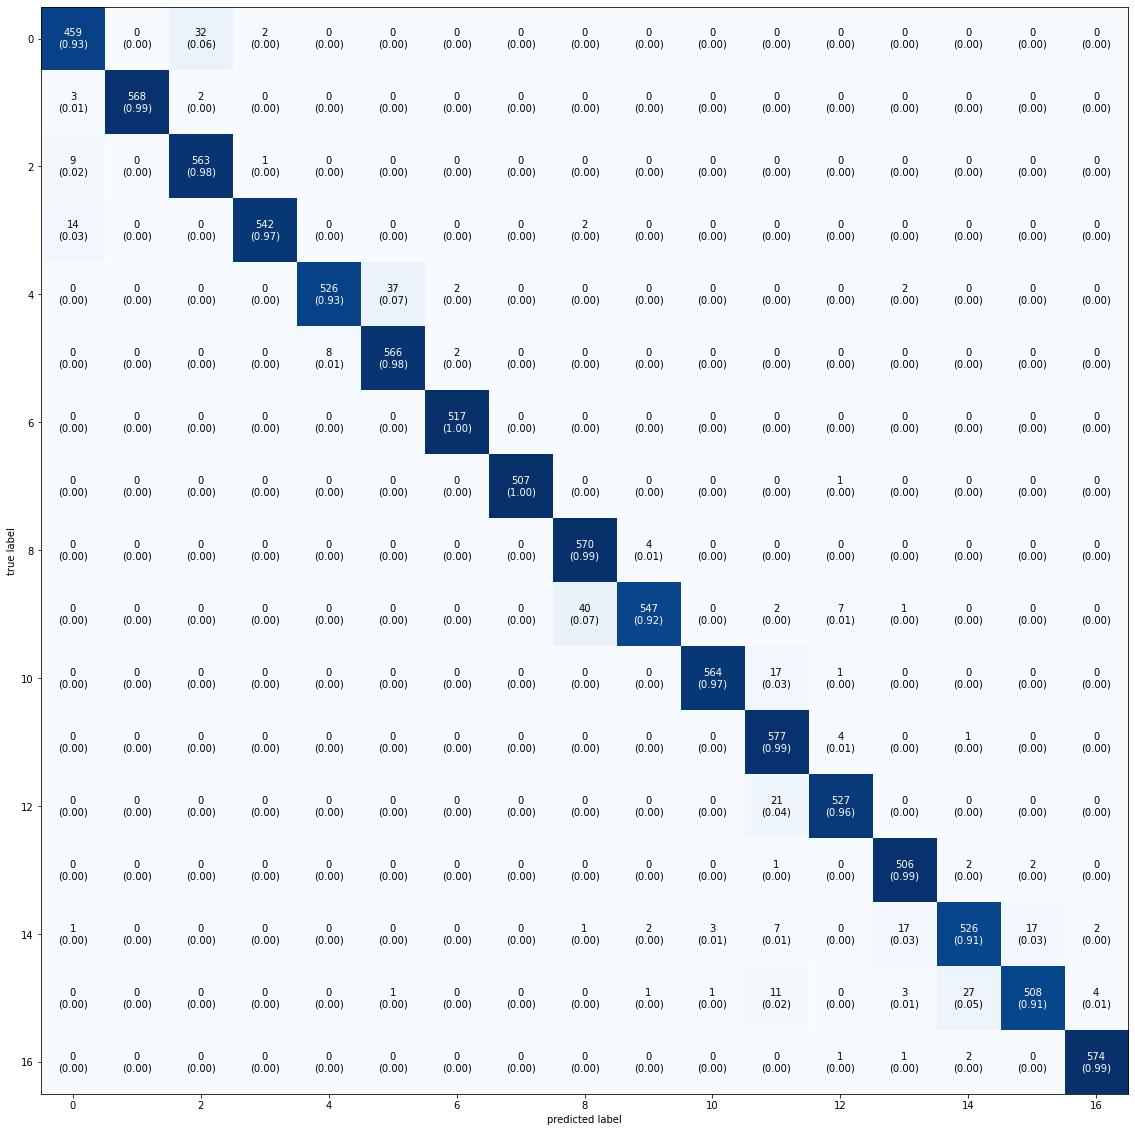

In [18]:
# test the model

for i in range(len(lable_list)):
  print(f"{i} : {lable_list[i]}")

predictions = model.predict_classes(test_set)

cm = confusion_matrix(test_set.classes, predictions)
plot_confusion_matrix(conf_mat = cm, 
                      figsize=(20,20),
                      show_normed=True)

In [19]:
# Ealuate the model
model.evaluate(test_set)

9469/9469 [==============================] - 35s 4ms/step - loss: 0.0915 - accuracy: 0.9660


[0.09146416932344437, 0.9659942984580994]

In [20]:
# test the accuracy of the trained model
test_accuracy = 0

for i in range(len(lable_list)):
    test_accuracy = test_accuracy + cm[i, i]
    
test_accuracy = test_accuracy / len(test_set)
    
print("Test Accuracy: {}%".format(round(test_accuracy * 100, 3)))

Test Accuracy: 96.599%


In [22]:
from sklearn.metrics import classification_report

print (classification_report(test_set.classes, predictions))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       493
           1       1.00      0.99      1.00       573
           2       0.94      0.98      0.96       573
           3       0.99      0.97      0.98       558
           4       0.99      0.93      0.96       567
           5       0.94      0.98      0.96       576
           6       0.99      1.00      1.00       517
           7       1.00      1.00      1.00       508
           8       0.93      0.99      0.96       574
           9       0.99      0.92      0.95       597
          10       0.99      0.97      0.98       582
          11       0.91      0.99      0.95       582
          12       0.97      0.96      0.97       548
          13       0.95      0.99      0.97       511
          14       0.94      0.91      0.93       576
          15       0.96      0.91      0.94       556
          16       0.99      0.99      0.99       578

    accuracy              

In [26]:
# save the model for later use
model.save("./modelfinal.h5")

In [27]:
model.save_weights("./weightsfinal.hdf5")

In [3]:
# Load the model
from tensorflow import keras
model2 = keras.models.load_model("/kaggle/input/modelfinal/modelfinal.h5")

(<Figure size 1440x1440 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

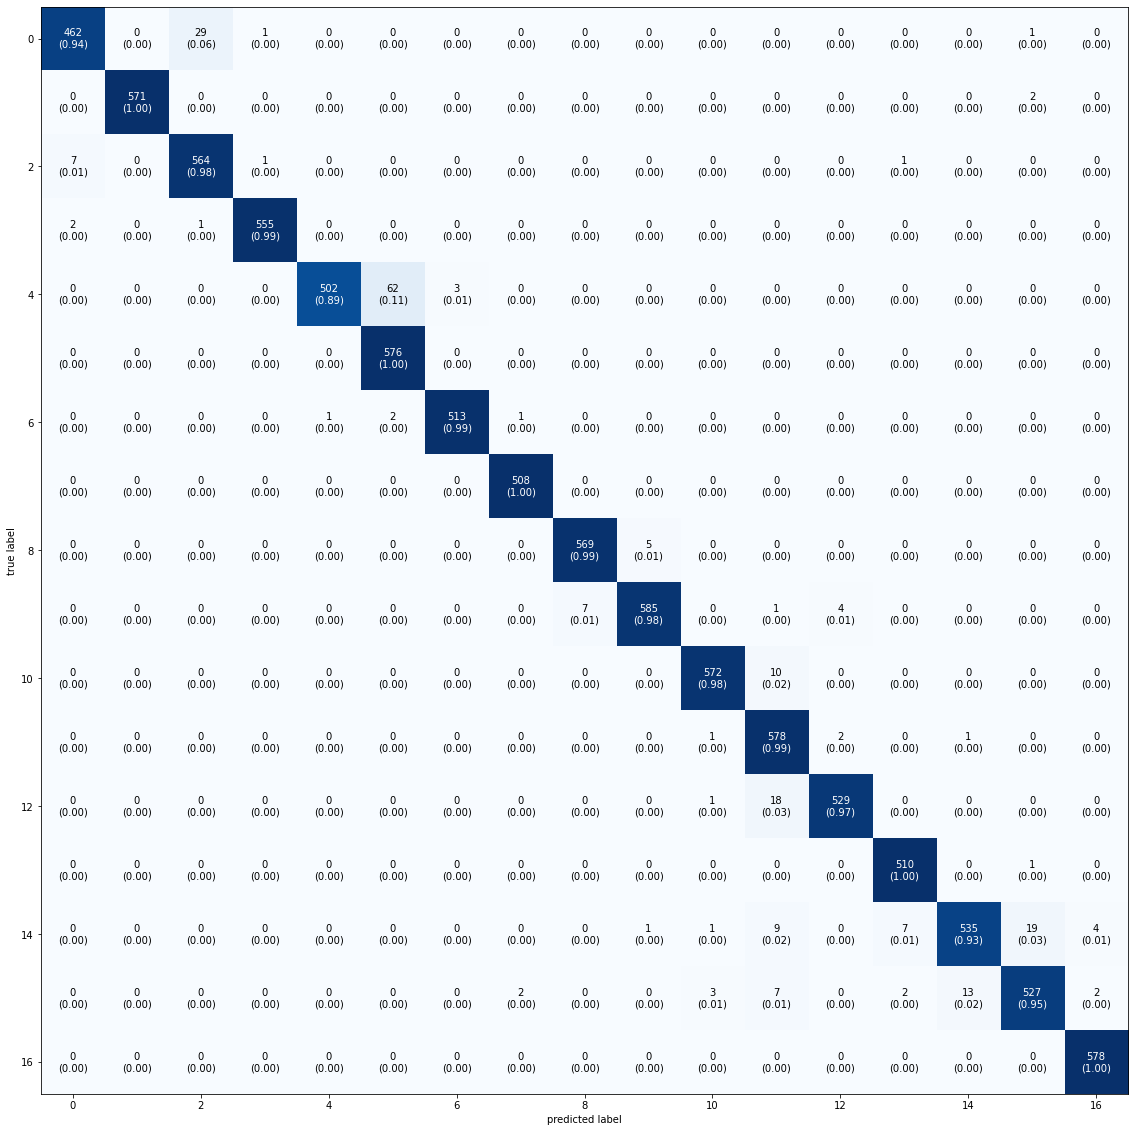

In [13]:
predictions = model2.predict_classes(test_set)

cm = confusion_matrix(test_set.classes, predictions)
plot_confusion_matrix(conf_mat = cm, 
                      figsize=(20,20),
                      show_normed=True)

In [33]:
# predict the external data and store the result

from keras.preprocessing import image

#external_path = '/kaggle/input/classification-leaf/External_class'

external_path = '../input/teset2222'

external_set = glob.glob(external_path + '/*')

print(len(external_set))

5


In [14]:
metrics = []
for i in range(17):
    TP = cm[i][i]
    
    FP = 0
    for j in range(17):
        if j != i:
            FP = FP + cm[i][j]
            
    FN = 0
    for k in range(17):
        if k != i:
            FN = FN + cm[k][i]
    
    TN = 0
    for m in range(17):
        if m != i:
            for n in range(17):
                if n != i:
                    TN = TN + cm[m][n]
                    
    temp = [TP,FP,FN,TN]
    metrics.append(temp)
    
print(metrics)

[[462, 31, 9, 8967], [571, 2, 0, 8896], [564, 9, 30, 8866], [555, 3, 2, 8909], [502, 65, 1, 8901], [576, 0, 64, 8829], [513, 4, 3, 8949], [508, 0, 3, 8958], [569, 5, 7, 8888], [585, 12, 6, 8866], [572, 10, 6, 8881], [578, 4, 45, 8842], [529, 19, 6, 8915], [510, 1, 10, 8948], [535, 41, 14, 8879], [527, 29, 23, 8890], [578, 0, 6, 8885]]


In [18]:
sensitivity = []
specificity = []
for e in metrics:
    sensitivity.append(e[0] / (e[2] + e[0]))
    specificity.append(e[3] / (e[1] + e[3]))

for i in range(17):
    sensitivity[i] = sensitivity[i] * 100
    specificity[i] = specificity[i] * 100

print(sensitivity)
print(specificity)

[98.08917197452229, 100.0, 94.94949494949495, 99.64093357271095, 99.80119284294234, 90.0, 99.4186046511628, 99.412915851272, 98.78472222222221, 98.98477157360406, 98.96193771626297, 92.776886035313, 98.8785046728972, 98.07692307692307, 97.44990892531877, 95.81818181818181, 98.97260273972603]
[99.65547899533229, 99.97752303888514, 99.89859154929577, 99.96633752244165, 99.27503903635959, 100.0, 99.95532223835586, 100.0, 99.94377600359834, 99.86483442216716, 99.8875267124058, 99.95478182229256, 99.7873293037833, 99.98882556710247, 99.54035874439462, 99.67485144074448, 100.0]


In [ ]:
def add_labels(data, label):
    return list(map(lambda x: (x, label), data))

external = add_labels(external_set, 'test')
print(external[0])

ext_df = pd.DataFrame(external, columns=['image', 'label'])
print('Size of external set: ',len(ext_df))

ext_rescaled = ImageDataGenerator(rescale = 1./255)
ext_set = ext_rescaled.flow_from_dataframe(dataframe=ext_df,
                                             x_col='image',
                                             y_col='label',
                                             target_size=(image_size, image_size),
                                             batch_size=1,
                                             shuffle=False,
                                             class_mode='categorical',
                                             color_mode='grayscale')

In [ ]:
for image in external:
    print(image[0])

In [ ]:
arr = model2.predict(ext_set)

In [ ]:
# print result for testing external data

print(len(arr))


for i in range(len(arr)):
    file = list(arr[i])
    print(f"File {i}: ",file.index(max(file)), " class")